### 1.	Collate the 2 excel files to have all the information at one place. Check for missing values and duplicates before joining the 2 datasets.

In [1]:
# All libraries/functions required

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
import plotly.express as px
from statsmodels.formula.api import ols
import statsmodels.api  as sm
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
hosp = pd.read_csv('Hospitalisation details.csv',)
medic = pd.read_csv('Medical Examinations.csv',)
names = pd.read_excel('Names.xlsx')

## Data inspection using .info()

In [3]:
hosp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Customer ID    2343 non-null   object 
 1   year           2343 non-null   object 
 2   month          2343 non-null   object 
 3   date           2343 non-null   int64  
 4   children       2343 non-null   int64  
 5   charges        2343 non-null   float64
 6   Hospital tier  2343 non-null   object 
 7   City tier      2343 non-null   object 
 8   State ID       2343 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 164.9+ KB


In [4]:
medic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             2335 non-null   object 
 1   BMI                     2335 non-null   float64
 2   HBA1C                   2335 non-null   float64
 3   Heart Issues            2335 non-null   object 
 4   Any Transplants         2335 non-null   object 
 5   Cancer history          2335 non-null   object 
 6   NumberOfMajorSurgeries  2335 non-null   object 
 7   smoker                  2335 non-null   object 
dtypes: float64(2), object(6)
memory usage: 146.1+ KB


In [5]:
names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Customer ID  2335 non-null   object
 1   name         2335 non-null   object
dtypes: object(2)
memory usage: 36.6+ KB


In [6]:
master_data = pd.merge(hosp, medic, how = 'inner', on = 'Customer ID')

In [7]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             2335 non-null   object 
 1   year                    2335 non-null   object 
 2   month                   2335 non-null   object 
 3   date                    2335 non-null   int64  
 4   children                2335 non-null   int64  
 5   charges                 2335 non-null   float64
 6   Hospital tier           2335 non-null   object 
 7   City tier               2335 non-null   object 
 8   State ID                2335 non-null   object 
 9   BMI                     2335 non-null   float64
 10  HBA1C                   2335 non-null   float64
 11  Heart Issues            2335 non-null   object 
 12  Any Transplants         2335 non-null   object 
 13  Cancer history          2335 non-null   object 
 14  NumberOfMajorSurgeries  2335 non-null   

In [8]:
master_data = master_data.merge(names,on='Customer ID')

In [9]:
master_data.head(2)

,Customer ID,year,month,date,children,charges,Hospital tier,City tier,State ID,BMI,HBA1C,Heart Issues,Any Transplants,Cancer history,NumberOfMajorSurgeries,smoker,name
0,Id2335,1992,Jul,9,0,563.84,tier - 2,tier - 3,R1013,17.58,4.51,No,No,No,1,No,"German, Mr. Aaron K"
1,Id2334,1992,Nov,30,0,570.62,tier - 2,tier - 1,R1013,17.60,4.39,No,No,No,1,No,"Rosendahl, Mr. Evan P"


In [10]:
master_data["City tier"].head()

0    tier - 3
1    tier - 1
2    tier - 1
3    tier - 3
4    tier - 3
Name: City tier, dtype: object

In [11]:
master_data.columns = master_data.columns.str.lower()
master_data.columns = master_data.columns.str.replace(' ', '_')
master_data.columns

Index(['customer_id', 'year', 'month', 'date', 'children', 'charges',
       'hospital_tier', 'city_tier', 'state_id', 'bmi', 'hba1c',
       'heart_issues', 'any_transplants', 'cancer_history',
       'numberofmajorsurgeries', 'smoker', 'name'],
      dtype='object')

In [12]:
master_data.city_tier

0       tier - 3
1       tier - 1
2       tier - 1
3       tier - 3
4       tier - 3
          ...   
2330    tier - 2
2331    tier - 3
2332    tier - 1
2333    tier - 3
2334    tier - 3
Name: city_tier, Length: 2335, dtype: object

### 2.	The data seems to have trivial values in a few variables. These are “?”. Find the percentage of rows which have such value (“?”) in any column. Delete such rows in case you don’t lose significant information. 

In [13]:
(master_data == '?').sum()

customer_id               0
year                      2
month                     3
date                      0
children                  0
charges                   0
hospital_tier             1
city_tier                 1
state_id                  2
bmi                       0
hba1c                     0
heart_issues              0
any_transplants           0
cancer_history            0
numberofmajorsurgeries    0
smoker                    2
name                      0
dtype: int64

In [14]:
# replacing '?' with np.NA for easy access and removal 

In [15]:
miss_perc = (master_data == '?').sum(axis = 1)/master_data.shape[1] * 100
miss_perc[miss_perc > 0]

11       5.882353
13       5.882353
17      11.764706
542      5.882353
1046     5.882353
1049     5.882353
1700     5.882353
1775     5.882353
2165     5.882353
2332     5.882353
dtype: float64

In [16]:
miss_perc[miss_perc>0].index

Index([11, 13, 17, 542, 1046, 1049, 1700, 1775, 2165, 2332], dtype='int64')

In [17]:
miss_perc_col = (master_data == '?').sum(axis = 0)/master_data.shape[0] * 100
miss_perc_col.sort_values(ascending= False)

month                     0.128480
state_id                  0.085653
year                      0.085653
smoker                    0.085653
city_tier                 0.042827
hospital_tier             0.042827
customer_id               0.000000
children                  0.000000
date                      0.000000
charges                   0.000000
bmi                       0.000000
heart_issues              0.000000
hba1c                     0.000000
any_transplants           0.000000
cancer_history            0.000000
numberofmajorsurgeries    0.000000
name                      0.000000
dtype: float64

In [18]:
master_noq = master_data.drop(index = miss_perc[miss_perc>0].index)
master_noq.shape

(2325, 17)

In [19]:
master_noq.isna().sum()

customer_id               0
year                      0
month                     0
date                      0
children                  0
charges                   0
hospital_tier             0
city_tier                 0
state_id                  0
bmi                       0
hba1c                     0
heart_issues              0
any_transplants           0
cancer_history            0
numberofmajorsurgeries    0
smoker                    0
name                      0
dtype: int64

### 3.	 The data has nominal and ordinal categorical variables. How are you going to incorporate these variables in the next steps of modelling. Use necessary transformation methods to deal with nominal and ordinal types of data.

In [20]:
master_noq[['city_tier', 'hospital_tier']]

,city_tier,hospital_tier
0,tier - 3,tier - 2
1,tier - 1,tier - 2
2,tier - 1,tier - 2
3,tier - 3,tier - 3
4,tier - 3,tier - 3
...,...,...
2329,tier - 3,tier - 1
2330,tier - 2,tier - 1
2331,tier - 3,tier - 1
2333,tier - 3,tier - 2


In [21]:
master_noq.state_id.value_counts()

state_id
R1013    609
R1011    574
R1012    572
R1024    159
R1026     84
R1021     70
R1016     64
R1025     40
R1023     38
R1017     36
R1019     26
R1022     14
R1014     13
R1015     11
R1018      9
R1020      6
Name: count, dtype: int64

In [22]:
# Using ordinalencoder to deal with ordinal categorical variables - city tier and hospital tier

ordinal = OrdinalEncoder(categories= [['tier - 3', 'tier - 2', 'tier - 1'],['tier - 3', 'tier - 2', 'tier - 1']])
master_noq[['city_tier_ord','hospital_tier_ord']] = ordinal.fit_transform(master_noq[['city_tier', 'hospital_tier']])

In [23]:
pd.crosstab(master_noq['city_tier_ord'],master_noq['city_tier'])

city_tier,tier - 1,tier - 2,tier - 3
city_tier_ord,,,
0.0,0,0,789
1.0,0,807,0
2.0,729,0,0


In [24]:
pd.crosstab(master_noq['hospital_tier_ord'],master_noq['hospital_tier'])

hospital_tier,tier - 1,tier - 2,tier - 3
hospital_tier_ord,,,
0.0,0,0,691
1.0,0,1334,0
2.0,300,0,0


In [25]:
master_noq.head(3)

,customer_id,year,month,date,children,charges,hospital_tier,city_tier,state_id,bmi,hba1c,heart_issues,any_transplants,cancer_history,numberofmajorsurgeries,smoker,name,city_tier_ord,hospital_tier_ord
0,Id2335,1992,Jul,9,0,563.84,tier - 2,tier - 3,R1013,17.58,4.51,No,No,No,1,No,"German, Mr. Aaron K",0.0,1.0
1,Id2334,1992,Nov,30,0,570.62,tier - 2,tier - 1,R1013,17.60,4.39,No,No,No,1,No,"Rosendahl, Mr. Evan P",2.0,1.0
2,Id2333,1993,Jun,30,0,600.00,tier - 2,tier - 1,R1013,16.47,6.35,No,No,Yes,1,No,"Albano, Ms. Julie",2.0,1.0


### 4.	State ID has around 16 states. The data does not have proportional representation of all the states. Also creating dummy variables corresponding to all the regions may lead to too many insignificant predictors. Nevertheless, only R1011, R1012 and R1013 are important to look deeper into. Keeping these ideas in mind, come up with a suitable strategy here.  

In [26]:
vc = master_noq.state_id.value_counts()   # frequency of each category
vc[:3].index                              # picking top 3 most frequent categories

Index(['R1013', 'R1011', 'R1012'], dtype='object', name='state_id')

In [27]:
for i in vc[:3].index:
    var_name = 'state_id_' +i   # create name for the dummy varible
    print(var_name)             
    master_noq[var_name] = 0    # giving a dummy value 0 to dummy variable
    master_noq.loc[master_noq.state_id == i,var_name] = 1  # replacing 0 by 1 where state id is equal to category of the dummy variable
            

state_id_R1013
state_id_R1011
state_id_R1012


In [28]:
master_noq.state_id.value_counts()

state_id
R1013    609
R1011    574
R1012    572
R1024    159
R1026     84
R1021     70
R1016     64
R1025     40
R1023     38
R1017     36
R1019     26
R1022     14
R1014     13
R1015     11
R1018      9
R1020      6
Name: count, dtype: int64

In [29]:
# checking the no of records corresponding to R1013

master_noq['state_id_R1013'].value_counts()

state_id_R1013
0    1716
1     609
Name: count, dtype: int64

In [30]:
master_noq['state_id_R1012'].value_counts()

state_id_R1012
0    1753
1     572
Name: count, dtype: int64

### 5.	Variable ‘NumberOfMajorSurvalue_counts seems to have string values as well. You may want to clean this variable. 

In [31]:
master_noq.numberofmajorsurgeries.unique()

array(['1', 'No major surgery', '2', '3'], dtype=object)

In [32]:
master_noq.loc[master_noq.numberofmajorsurgeries == 'No major surgery','numberofmajorsurgeries' ] = 0

In [33]:
master_noq.numberofmajorsurgeries = master_noq.numberofmajorsurgeries.astype(int)

### 6.	Age seems to an important factor for this analysis. Based on date of birth information, calculate the age of the patients. 

In [34]:
master_noq.year = master_noq.year.astype(int)

In [35]:
master_noq['age'] = 2023 - master_noq.year

### 7.	Gender of the patient may be an important factor to decide the hospitalization cost. Salutation provided in the name of the beneficiary can be used to determine the gender. Create a new field for the gender of beneficiary.

In [36]:
master_noq['title'] = master_noq.name.str.split('[,.]').str[1].str.strip()

In [37]:
master_noq.title.value_counts()

title
Mr     1160
Ms     1023
Mrs     142
Name: count, dtype: int64

In [38]:
master_noq.shape

(2325, 24)

In [39]:
1160+1023+142

2325

In [40]:
master_noq['gender'] = 'female'
master_noq.loc[master_noq.title == 'Mr', 'gender'] = 'male'

In [41]:
master_noq.loc[master_noq.title == 'Mrs']

,customer_id,year,month,date,children,charges,hospital_tier,city_tier,state_id,bmi,...,smoker,name,city_tier_ord,hospital_tier_ord,state_id_R1013,state_id_R1011,state_id_R1012,age,title,gender
24,Id2311,2001,Aug,19,0,964.71,tier - 3,tier - 2,R1013,25.19,...,No,"Keys, Mrs. Kathleen",1.0,0.0,1,0,0,22,Mrs,female
172,Id2163,2004,Dec,27,0,1863.45,tier - 3,tier - 1,R1025,27.06,...,No,"Stanislav, Mrs. Grace H",2.0,0.0,0,0,0,19,Mrs,female
197,Id2138,2004,Jun,12,0,2094.10,tier - 3,tier - 2,R1025,27.74,...,No,"Padula, Mrs. Lauren",1.0,0.0,0,0,0,19,Mrs,female
328,Id2007,1993,Sep,25,0,3162.02,tier - 2,tier - 3,R1013,25.61,...,No,"Martin, Mrs. Kristen M",0.0,1.0,1,0,0,30,Mrs,female
348,Id1987,2003,Dec,5,0,3300.70,tier - 2,tier - 2,R1025,30.54,...,No,"Mendez-Karr, Mrs. Cynthia",1.0,1.0,0,0,0,20,Mrs,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,Id545,1963,Jul,4,0,18208.34,tier - 1,tier - 2,R1026,44.20,...,No,"Shigezumi, Mrs. Teiko",1.0,2.0,0,0,0,60,Mrs,female
1808,Id527,1963,Dec,6,0,18883.33,tier - 1,tier - 1,R1026,46.19,...,No,"Hughey, Mrs. Ashley E",2.0,2.0,0,0,0,60,Mrs,female
1811,Id524,1963,Oct,20,0,18954.56,tier - 1,tier - 1,R1026,46.40,...,No,"Rogers, Mrs. Anita L.",2.0,2.0,0,0,0,60,Mrs,female
1839,Id496,1966,Aug,10,0,19995.29,tier - 1,tier - 3,R1026,51.74,...,No,"Oehlke, Mrs. Jessica",0.0,2.0,0,0,0,57,Mrs,female


In [42]:
master_noq['gender']

0         male
1         male
2       female
3         male
4         male
         ...  
2329      male
2330    female
2331    female
2333      male
2334    female
Name: gender, Length: 2325, dtype: object

### 8.	Visualize the distribution of cost using histogram, box and whisker and swarm plot. How the distribution is different across gender and different tiers of hospitals. Share your observation.  

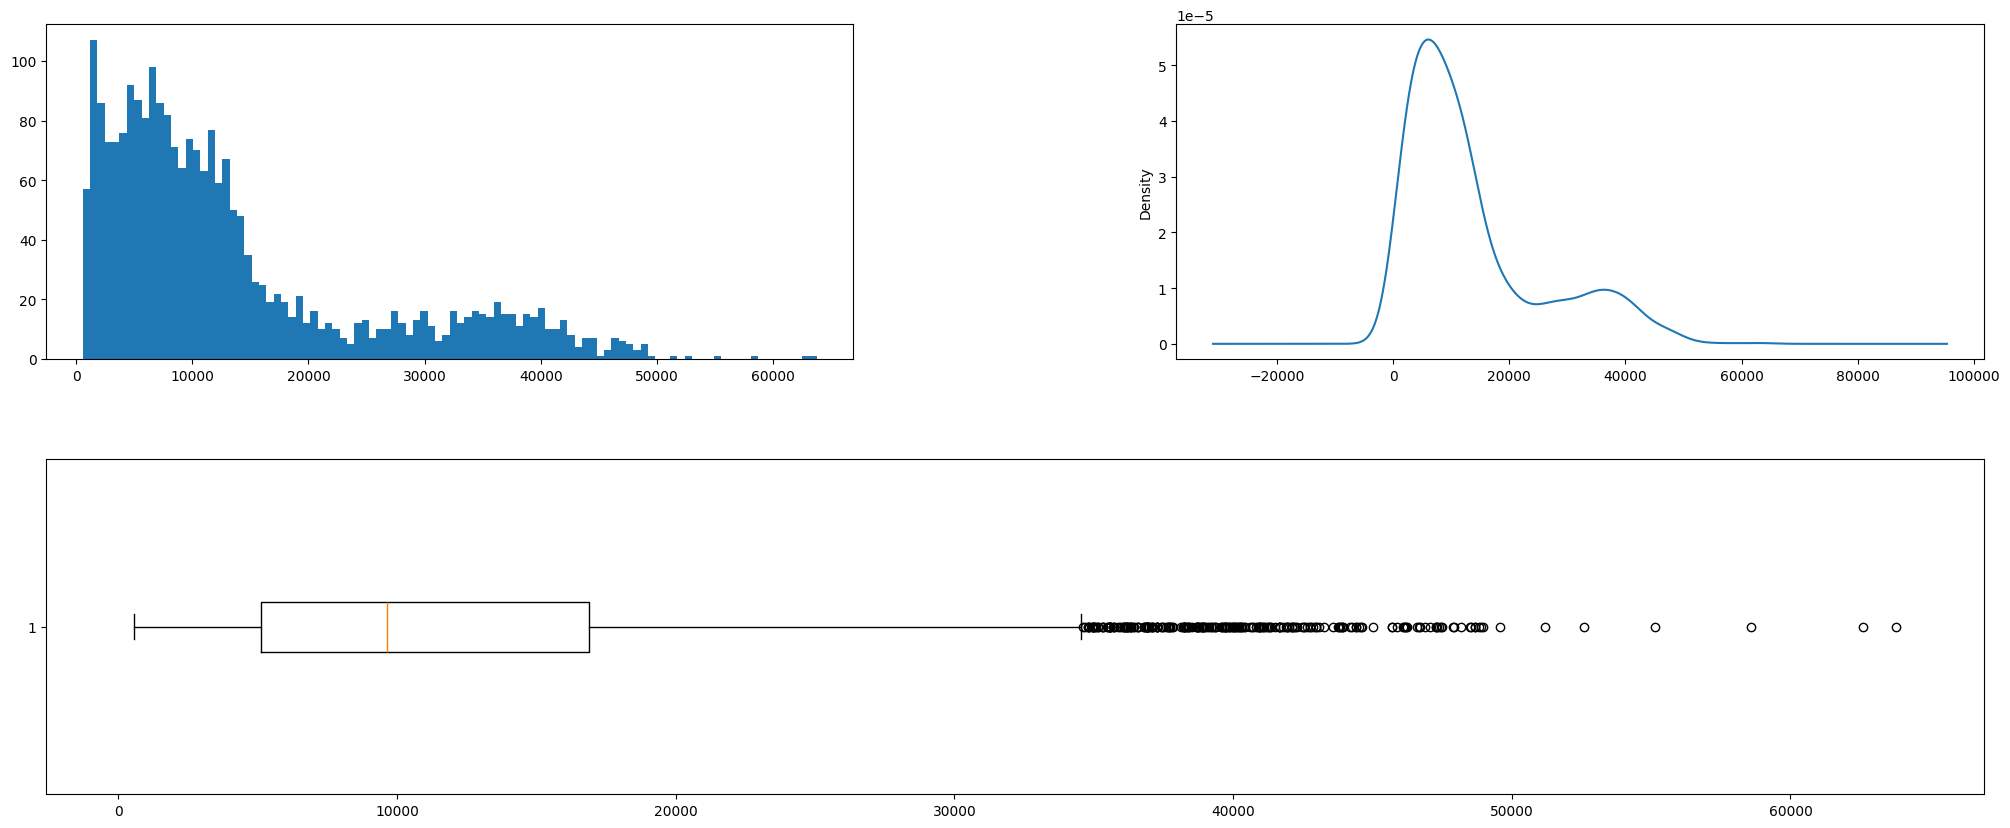

In [43]:
plt.figure(figsize = (25,10))
grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)
plt.subplot(grid[0, 0])
plt.hist(master_noq.charges, bins = 100)
plt.subplot(grid[0, 1])
master_noq.charges.plot.kde()
plt.subplot(grid[1, :])
plt.boxplot(master_noq.charges, vert = False)
plt.show()

## WRT gender

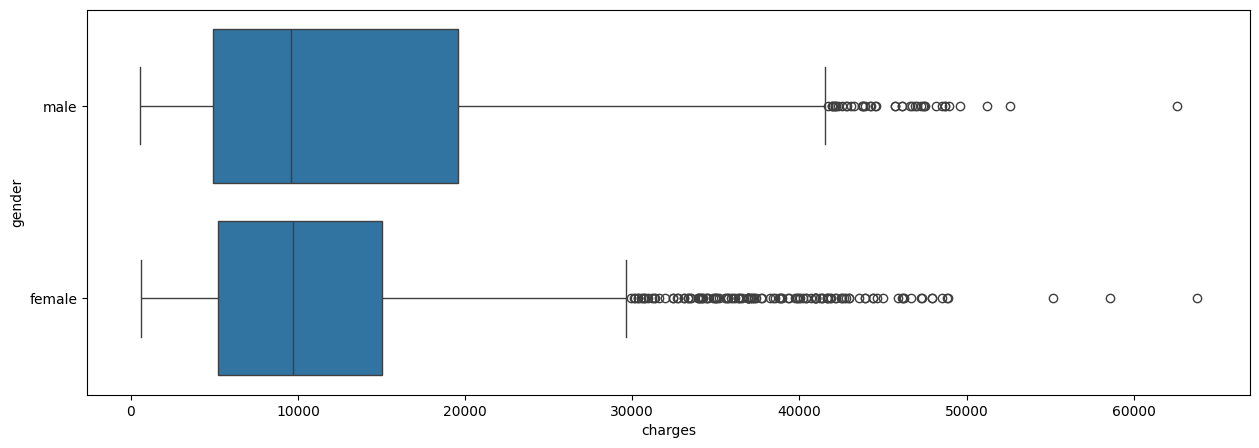

In [44]:
plt.figure(figsize = (15,5))
sns.boxplot(x = "charges",y = "gender", data = master_noq)
plt.show()

## WRT city tier 

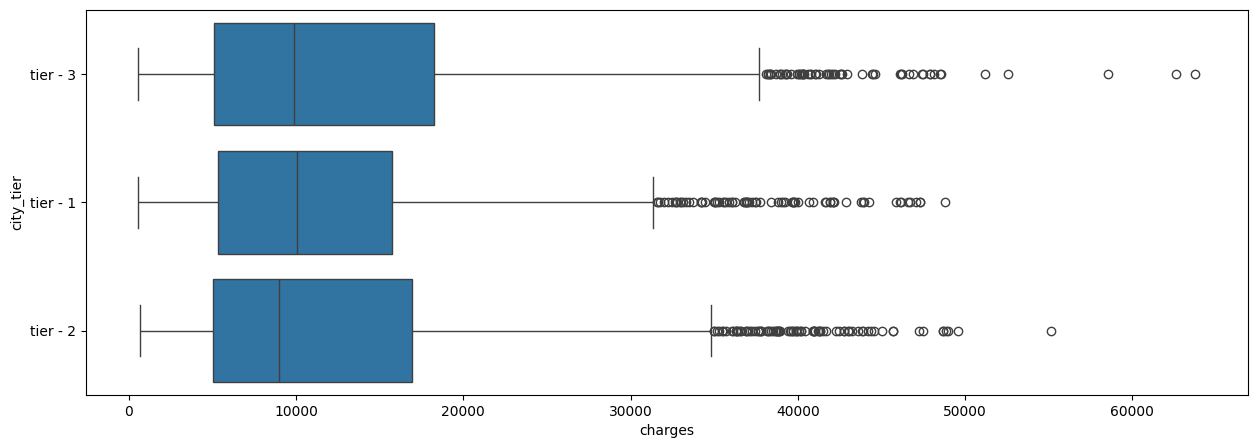

In [45]:
plt.figure(figsize = (15,5))
sns.boxplot(x = "charges",y = "city_tier", data = master_noq)
plt.show()

## WRT Hospital tier

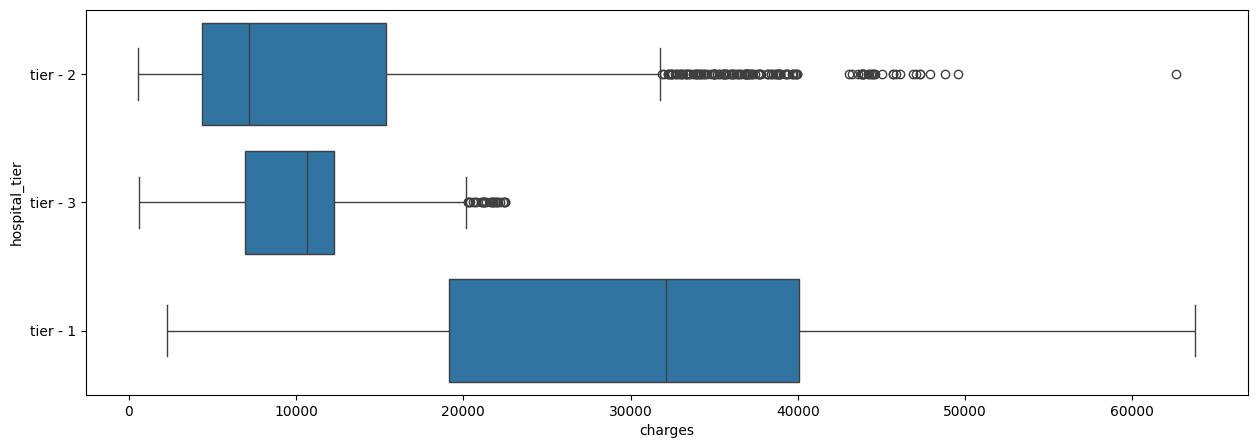

In [46]:
plt.figure(figsize = (15,5))
sns.boxplot(x = "charges",y = "hospital_tier", data = master_noq)
plt.show()

### 9.	Create a radar chart to showcase the median hospitalization cost across different tiers of hospitals.

In [47]:
median = master_noq.groupby('hospital_tier')[['charges']].median().reset_index()

In [48]:
fig = px.line_polar(median, r='charges', theta='hospital_tier') #, line_close=True
fig.show()

### 10.	Create a frequency table and hence a stacked bar-chart to visualize the count of people in different tiers of cities and hospitals.   

In [49]:
pd.crosstab(master_noq.city_tier, master_noq.hospital_tier)

hospital_tier,tier - 1,tier - 2,tier - 3
city_tier,,,
tier - 1,85,403,241
tier - 2,106,479,222
tier - 3,109,452,228


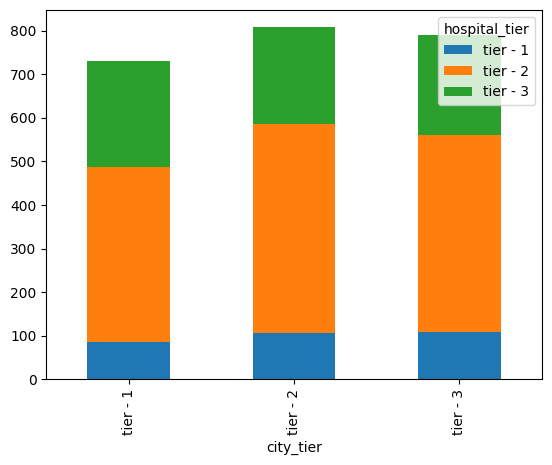

In [50]:
pd.crosstab(master_noq.city_tier, master_noq.hospital_tier).plot.bar(stacked = True)
plt.show()

### 11.	Test the following null hypotheses:
    - Average hospitalization cost across the 3 types of hospitals is not significantly different  
    - Average hospitalization cost across the 3 types of cities is not significantly different 
    - Average hospitalization cost for smokers is not significantly different than non-smokers
    - Smoking and Hearth issues are independent

#### H0 : Average hospitalization cost across the 3 types of hospitals is not significantly different

In [51]:
mod = ols('charges ~ hospital_tier', data = master_noq).fit()
res = sm.stats.anova_lm(mod)
res

,df,sum_sq,mean_sq,F,PR(>F)
hospital_tier,2.0,9.763011e+10,4.881505e+10,493.989566,1.773822e-179
Residual,2322.0,2.294554e+11,9.881799e+07,NaN,NaN


#### H0 = Average hospitalization cost across the 3 types of cities is not significantly different

In [52]:
mod = ols('charges ~ city_tier', data = master_noq).fit()
res = sm.stats.anova_lm(mod)
res

,df,sum_sq,mean_sq,F,PR(>F)
city_tier,2.0,4.092192e+08,2.046096e+08,1.454356,0.233763
Residual,2322.0,3.266763e+11,1.406874e+08,NaN,NaN


#### H0: Average hospitalization cost for smokers is not significantly different than non-smokers

In [53]:
sample1 = master_noq.loc[master_noq.smoker == 'yes', 'charges']
sample2 = master_noq.loc[master_noq.smoker != 'yes', 'charges']
stats.ttest_ind(sample1, sample2)

TtestResult(statistic=np.float64(74.15560699695726), pvalue=np.float64(0.0), df=np.float64(2323.0))

#### H0 : Smoking and Heart issues are independent4

In [54]:
observed_table = pd.crosstab(master_noq.smoker, master_data.heart_issues)

In [55]:
observed_table

heart_issues,No,yes
smoker,,
No,1108,731
yes,297,189


In [56]:
chi, p, df, expected = stats.chi2_contingency(observed_table)

In [57]:
chi, p, df, expected

(np.float64(0.08588150449910657),
 np.float64(0.7694797581780767),
 1,
 array([[1111.30967742,  727.69032258],
        [ 293.69032258,  192.30967742]]))

## 12.	Check the correlation between predictors to identify highly correlated predictors. Visualize using a heatmap.

In [58]:
master_noq.columns 

Index(['customer_id', 'year', 'month', 'date', 'children', 'charges',
       'hospital_tier', 'city_tier', 'state_id', 'bmi', 'hba1c',
       'heart_issues', 'any_transplants', 'cancer_history',
       'numberofmajorsurgeries', 'smoker', 'name', 'city_tier_ord',
       'hospital_tier_ord', 'state_id_R1013', 'state_id_R1011',
       'state_id_R1012', 'age', 'title', 'gender'],
      dtype='object')

In [59]:
data = master_noq.drop(columns = ['customer_id','name', 'year', 'month', 'date','hospital_tier',
       'city_tier', 'state_id' , 'title'])

In [60]:
corr_plot = data.select_dtypes(exclude='object').corr()
ma = np.ones_like(corr_plot)
ma[np.tril_indices_from(ma)] = 0

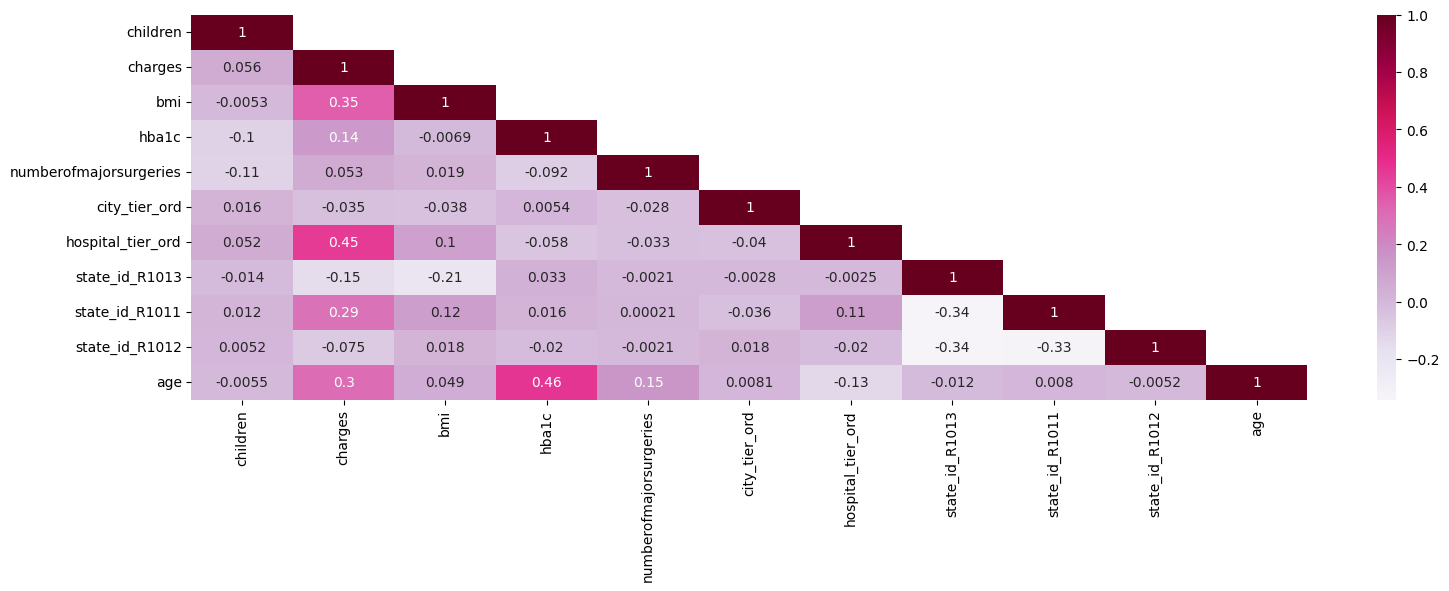

In [61]:
plt.figure(figsize = (18,5))
sns.heatmap(corr_plot, annot= True , mask = ma, cmap='PuRd')
plt.show()

#### 13. Final Model Development and Evaluation :
Perform stratified 5-fold cross validation technique for final prediction and validation. Make sure to use standardization, hyperparameter tuning effectively. There must be effective use of sklearn-pipelines. 
a. Create 5 fold in the data. You may want to create a variable to identify the folds. 

In [62]:
data_2 = pd.get_dummies(data, drop_first=True)
data_2.reset_index(drop=True, inplace = True)

In [63]:
data_2.head()

,children,charges,bmi,hba1c,numberofmajorsurgeries,city_tier_ord,hospital_tier_ord,state_id_R1013,state_id_R1011,state_id_R1012,age,heart_issues_yes,any_transplants_yes,cancer_history_Yes,smoker_yes,gender_male
0,0,563.84,17.58,4.51,1,0.0,1.0,1,0,0,31,False,False,False,False,True
1,0,570.62,17.60,4.39,1,2.0,1.0,1,0,0,31,False,False,False,False,True
2,0,600.00,16.47,6.35,1,2.0,1.0,1,0,0,30,False,False,True,False,False
3,0,604.54,17.70,6.28,1,0.0,0.0,1,0,0,31,False,False,False,False,True
4,0,637.26,22.34,5.57,1,0.0,0.0,1,0,0,25,False,False,False,False,True


In [64]:
# rearrange data to put 'charges' as first column or last
model_data = data_2.drop(columns = 'charges')
model_data.head()
model_data['charges'] = data_2.charges
model_data.head()

,children,bmi,hba1c,numberofmajorsurgeries,city_tier_ord,hospital_tier_ord,state_id_R1013,state_id_R1011,state_id_R1012,age,heart_issues_yes,any_transplants_yes,cancer_history_Yes,smoker_yes,gender_male,charges
0,0,17.58,4.51,1,0.0,1.0,1,0,0,31,False,False,False,False,True,563.84
1,0,17.60,4.39,1,2.0,1.0,1,0,0,31,False,False,False,False,True,570.62
2,0,16.47,6.35,1,2.0,1.0,1,0,0,30,False,False,True,False,False,600.00
3,0,17.70,6.28,1,0.0,0.0,1,0,0,31,False,False,False,False,True,604.54
4,0,22.34,5.57,1,0.0,0.0,1,0,0,25,False,False,False,False,True,637.26


In [65]:
model_data.columns = model_data.columns.str.lower()

In [66]:
model_data.columns

Index(['children', 'bmi', 'hba1c', 'numberofmajorsurgeries', 'city_tier_ord',
       'hospital_tier_ord', 'state_id_r1013', 'state_id_r1011',
       'state_id_r1012', 'age', 'heart_issues_yes', 'any_transplants_yes',
       'cancer_history_yes', 'smoker_yes', 'gender_male', 'charges'],
      dtype='object')

In [67]:
# converting y to categorical for stratified k fold
y = model_data['charges']
X = model_data.drop(columns = 'charges')

In [68]:
X.head()

,children,bmi,hba1c,numberofmajorsurgeries,city_tier_ord,hospital_tier_ord,state_id_r1013,state_id_r1011,state_id_r1012,age,heart_issues_yes,any_transplants_yes,cancer_history_yes,smoker_yes,gender_male
0,0,17.58,4.51,1,0.0,1.0,1,0,0,31,False,False,False,False,True
1,0,17.60,4.39,1,2.0,1.0,1,0,0,31,False,False,False,False,True
2,0,16.47,6.35,1,2.0,1.0,1,0,0,30,False,False,True,False,False
3,0,17.70,6.28,1,0.0,0.0,1,0,0,31,False,False,False,False,True
4,0,22.34,5.57,1,0.0,0.0,1,0,0,25,False,False,False,False,True


In [69]:
#scoring='neg_root_mean_squared_error'

In [70]:
#Setting up a pipeline
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('regressor', Ridge())])

In [71]:
# Defining the parameters for hyperparameter tuning
parameters = {'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [72]:
# Creating the KFold object
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [73]:
# Creating the grid search object
model_ridge = GridSearchCV(pipeline, parameters, cv=kfold, scoring='neg_mean_squared_error')


In [74]:
model_ridge.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', Ridge())]),
             param_grid={'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [75]:
# Getting the best parameters and the best model
model_ridge.best_params_

{'regressor__alpha': 10}

In [76]:
model_ridge.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('regressor', Ridge(alpha=10))])

## Gradient Boosting Algorithm

In [77]:
from sklearn.ensemble import GradientBoostingRegressor

In [78]:
# Assuming df is your DataFrame
# Use df appropriately to prepare X (input) and y (output)

# Split the data into training and testing sets
# (Make sure to replace X and y with your data appropriately)
X_train,X_test,y_train,y_test = train_test_split(X,y)
# Train the XGBoost model
model = GradientBoostingRegressor()
model.fit(X_train, y_train)


# You can print the feature importances if needed
print(model.feature_importances_)

# Identify redundant variables based on the importance scores

[5.90716288e-03 1.15114472e-01 4.26565830e-03 1.04663487e-04
 3.11202795e-04 2.23516356e-02 4.37893395e-03 7.27246020e-03
 4.86825060e-05 8.99198619e-02 7.43786656e-06 1.09264565e-05
 2.91256819e-04 7.49632782e-01 3.82862749e-04]


#### Variable Importance

In [79]:
pd.DataFrame({'Features':model.feature_names_in_,'Importance':model.feature_importances_}).sort_values("Importance",ascending=False)

,Features,Importance
13,smoker_yes,0.749633
1,bmi,0.115114
9,age,0.089920
5,hospital_tier_ord,0.022352
7,state_id_r1011,0.007272
0,children,0.005907
6,state_id_r1013,0.004379
2,hba1c,0.004266
14,gender_male,0.000383
4,city_tier_ord,0.000311


In [80]:
# train score
model.score(X_train,y_train)

0.9358575424973825

In [81]:
# test score
model.score(X_test,y_test)

0.9125064256478321

## 15. Predict the hospitalization cost for Christopher, Ms. Jayna (Date of birth – 12/28/1988, height 170 cm and weight 85 kgs). She resides in a tier1 city (state : stateid = R1011) with husband and 2 of her kids. She is tested non-diabetic ( hbA1c = 5.8). She smokes but otherwise she is healthy, no transplants and no major surgeries so far. Her father had lung cancer and that was the reason of his early demise. Hospitalization cost to predicted considering tier1 hospitals.  

Find predicted  hospitalization cost based on all the 5 models. The predicted value should be mean of all the 5 predicted values from the 5 models.


In [82]:
model_data.columns

Index(['children', 'bmi', 'hba1c', 'numberofmajorsurgeries', 'city_tier_ord',
       'hospital_tier_ord', 'state_id_r1013', 'state_id_r1011',
       'state_id_r1012', 'age', 'heart_issues_yes', 'any_transplants_yes',
       'cancer_history_yes', 'smoker_yes', 'gender_male', 'charges'],
      dtype='object')

In [83]:
pred_data = pd.DataFrame({'Name' : ['Christopher, Ms. Jayna'],
                      'DOB' : ['12/28/1988'],
                      'city_tier' : ['tier - 1'], 'children' :[ 2],
                       'HbA1c' : [5.8], 
                       'smoker_yes' : [1],
                       'heart_issues_yes' : [0],
                       'any_transplants_yes' : [0],
                       'numberofmajorsurgeries' :[ 0],
                       'cancer_history_yes' : [1],
                       'hospital_tier' : ['tier - 1'],
                       'bmi' : [85/(1.70 **2)],
                       'state_id_R1011' : [1]
                      })

In [84]:
pred_data

,Name,DOB,city_tier,children,HbA1c,smoker_yes,heart_issues_yes,any_transplants_yes,numberofmajorsurgeries,cancer_history_yes,hospital_tier,bmi,state_id_R1011
0,"Christopher, Ms. Jayna",12/28/1988,tier - 1,2,5.8,1,0,0,0,1,tier - 1,29.411765,1


In [85]:
pred_data.columns = pred_data.columns.str.lower()    
    

In [86]:
# we will create columns according to the final model data already created

In [87]:
pred_data['gender_male']  = 0
pred_data.loc[pred_data.name.str.split('[,.]').str[1] == 'Mr', 'gender_male'] = 1
pred_data.drop(columns = 'name', inplace = True)

In [88]:
pred_data

,dob,city_tier,children,hba1c,smoker_yes,heart_issues_yes,any_transplants_yes,numberofmajorsurgeries,cancer_history_yes,hospital_tier,bmi,state_id_r1011,gender_male
0,12/28/1988,tier - 1,2,5.8,1,0,0,0,1,tier - 1,29.411765,1,0


In [89]:
#pred_data['age'] =2023 - pred_data.dob.astype(np.datetime64).dt.year

In [90]:
pred_data.drop(columns = 'dob', inplace = True)

In [91]:
pred_data[['city_tier_ord', 'hospital_tier_ord']] = ordinal.transform(pred_data[['city_tier', 'hospital_tier']])

In [92]:
pred_data.drop(columns =['city_tier', 'hospital_tier'], inplace = True )

In [93]:
# initializing the missing columns with 0 and not include charges

In [94]:
for col in model_data.columns:
    if col not in pred_data.columns and col != 'charges':
        pred_data[col] = 0

In [95]:
pred_data

,children,hba1c,smoker_yes,heart_issues_yes,any_transplants_yes,numberofmajorsurgeries,cancer_history_yes,bmi,state_id_r1011,gender_male,city_tier_ord,hospital_tier_ord,state_id_r1013,state_id_r1012,age
0,2,5.8,1,0,0,0,1,29.411765,1,0,2.0,2.0,0,0,0


In [96]:
### Apply Gradient BOOST model for predi
model_data.columns

Index(['children', 'bmi', 'hba1c', 'numberofmajorsurgeries', 'city_tier_ord',
       'hospital_tier_ord', 'state_id_r1013', 'state_id_r1011',
       'state_id_r1012', 'age', 'heart_issues_yes', 'any_transplants_yes',
       'cancer_history_yes', 'smoker_yes', 'gender_male', 'charges'],
      dtype='object')

In [97]:
pred_data.columns

Index(['children', 'hba1c', 'smoker_yes', 'heart_issues_yes',
       'any_transplants_yes', 'numberofmajorsurgeries', 'cancer_history_yes',
       'bmi', 'state_id_r1011', 'gender_male', 'city_tier_ord',
       'hospital_tier_ord', 'state_id_r1013', 'state_id_r1012', 'age'],
      dtype='object')

In [98]:
pred_data=pred_data[model_data.drop(columns='charges').columns]

In [99]:
model.predict(pred_data)

array([26682.74689192])